<a href="https://colab.research.google.com/github/nazilaeshghi/from-rep/blob/main/NazilaEshghi_Zoomcamp2024_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework

> Note: sometimes your answer doesn't match one of
> the options exactly. That's fine.
> Select the option that's closest to your solution.


In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

You can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
unzip bank+marketing.zip
unzip bank.zip
```

We need `bank-full.csv`.

In this dataset the target variable is `y` variable - has the client subscribed a term deposit or not.

### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`



Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`




In [44]:
import pandas as pd
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score # Importing roc_auc_score function
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [45]:
df=pd.read_csv('bank-full.csv', delimiter=';')

In [46]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [47]:
df[['age','job','marital','education','balance','housing','contact','day','month','duration','campaign','pdays','previous','poutcome','y']]

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,1729,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,5715,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,668,no,telephone,17,nov,508,4,-1,0,unknown,no


In [48]:
from sklearn.model_selection import train_test_split

# Split into train and test (80% / 20%)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Split full train into train and validation (60% / 20% of original data)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
# 0.25 x 0.8 = 0.2

# Verify the shapes of the resulting DataFrames
print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (27126, 17)
Validation shape: (9042, 17)
Test shape: (9043, 17)



### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

In [49]:
# Convert 'y' column to numerical (0 and 1)
df_train['y'] = (df_train['y'] == 'yes').astype(int)

# Numerical variables to consider
numerical_variables = ['balance', 'day', 'duration', 'previous']

# Calculate AUC for each variable, checking for single-class issue
auc_scores = {}
for variable in numerical_variables:
    # Check if 'y' has both classes for this variable
    if len(df_train['y'].unique()) > 1:  # Check unique values in 'y'
        auc = roc_auc_score(df_train['y'], df_train[variable])
        auc_scores[variable] = auc
    else:
        print(f"Warning: Variable '{variable}' has only one class in 'y'. Skipping AUC calculation.")

# Find the variable with the highest AUC (if any were calculated)
if auc_scores:  # Check if auc_scores is not empty
    highest_auc_variable = max(auc_scores, key=auc_scores.get)
    print("AUC Scores:")
    for variable, auc in auc_scores.items():
        print(f"{variable}: {auc:.4f}")

    print(f"\nNumerical variable with highest AUC: {highest_auc_variable}")
else:
    print("No AUC scores could be calculated due to single-class issues.")

AUC Scores:
balance: 0.5888
day: 0.4740
duration: 0.8147
previous: 0.5986

Numerical variable with highest AUC: duration


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [50]:
# Split into train and test (80% / 20%)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Split full train into train and validation (60% / 20% of original data)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Convert 'y' column to numerical (0 and 1) in both training AND validation
df_train['y'] = (df_train['y'] == 'yes').astype(int)
df_val['y'] = (df_val['y'] == 'yes').astype(int)

# Features to use for training
features = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']

# Convert data to dictionaries for DictVectorizer
train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

# Create and fit DictVectorizer
dv = DictVectorizer(sparse=False)  # sparse=False for compatibility with LogisticRegression
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Target variables for training and validation
y_train = df_train['y'].values
y_val = df_val['y'].values

# Train Logistic Regression model with specified parameters
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities on validation set
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Calculate AUC score
auc = roc_auc_score(y_val, y_pred_proba)

print(f"AUC on validation dataset: {auc:.3f}")

AUC on validation dataset: 0.900


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

<ipython-input-57-3b5631f5de19>:50: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


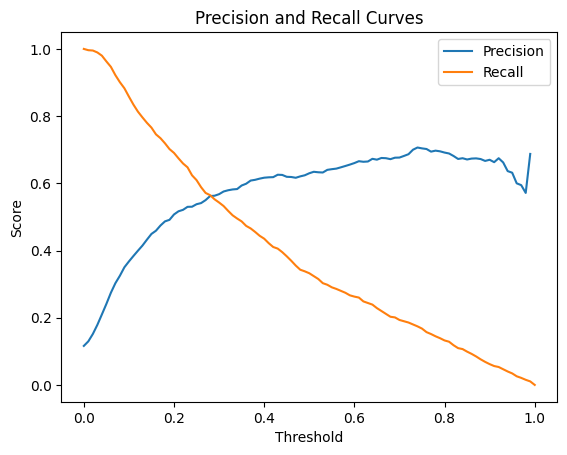

0.0


In [57]:
!pip install pandas scikit-learn matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

# ... (Previous code for data loading and preprocessing) ...

# Prepare the full training data
features = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
full_train_dicts = df_full_train[features].to_dict(orient='records')
y_full_train = (df_full_train['y'] == 'yes').astype(int).values

# Create and fit DictVectorizer on full training data
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(full_train_dicts)

# Train the final model with the best C value (1)
model = LogisticRegression(solver='liblinear', C=1, max_iter=1000)
model.fit(X_full_train, y_full_train)

# Prepare test data
test_dicts = df_test[features].to_dict(orient='records')
X_test = dv.transform(test_dicts)
y_test = (df_test['y'] == 'yes').astype(int).values

# Predict probabilities on test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Varying thresholds and calculating precision and recall
thresholds = list(range(0, 101, 1)) # 0 to 100
precision_scores = []
recall_scores = []
threshold_list=[]
for t in thresholds:
    threshold_list.append(t / 100)
    actual_positive = (y_test == 1)
    actual_negative = (y_test == 0)

    predict_positive = (y_pred_proba >= t/100)
    predict_negative = (y_pred_proba < t/100)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    precision_scores.append(precision)
    recall_scores.append(recall)

# Plotting precision and recall curves
plt.plot(threshold_list, precision_scores, label='Precision')
plt.plot(threshold_list, recall_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves')
plt.legend()
plt.show()

# Finding the intersection point
idx = 0
for i in range(len(threshold_list)):
    if precision_scores[i] <= recall_scores[i]:
        idx = i
        break

# Assuming thresholds and scores are lists of equal length
print(threshold_list[idx])

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

In [58]:
!pip install pandas scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# ... (Previous code for data loading, preprocessing, and model training) ...

# Predict probabilities on validation set
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Varying thresholds and calculating F1 score
thresholds = list(range(0, 101, 1)) # 0 to 100
f1_scores = []
threshold_list=[]
for t in thresholds:
    threshold_list.append(t / 100)
    y_pred = (y_pred_proba >= t/100).astype(int)  # Convert probabilities to predictions
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

# Find the threshold with maximum F1 score
max_f1_index = f1_scores.index(max(f1_scores))
max_f1_threshold = threshold_list[max_f1_index]

print(f"Threshold with maximum F1 score: {max_f1_threshold}")

Threshold with maximum F1 score: 0.25


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [59]:
!pip install pandas scikit-learn
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# ... (Previous code for data loading and preprocessing) ...

# Prepare the full training data
features = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
full_train_dicts = df_full_train[features].to_dict(orient='records')
y_full_train = (df_full_train['y'] == 'yes').astype(int).values

# Initialize KFold with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store AUC scores for each fold
auc_scores = []

# Iterate over folds
for train_index, val_index in kf.split(full_train_dicts):
    # Split data into train and validation for this fold
    X_train = [full_train_dicts[i] for i in train_index]
    X_val = [full_train_dicts[i] for i in val_index]
    y_train = y_full_train[train_index]
    y_val = y_full_train[val_index]

    # Create and fit DictVectorizer
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(X_train)
    X_val = dv.transform(X_val)

    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # Predict probabilities on validation set
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calculate AUC and append to scores
    auc = roc_auc_score(y_val, y_pred_proba)
    auc_scores.append(auc)

# Calculate standard deviation of AUC scores
std_dev = pd.Series(auc_scores).std()

print(f"Standard deviation of AUC scores across folds: {std_dev:.4f}")

Standard deviation of AUC scores across folds: 0.0063


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [60]:
!pip install pandas scikit-learn
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# ... (Previous code for data loading and preprocessing) ...

# Prepare the full training data
features = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
full_train_dicts = df_full_train[features].to_dict(orient='records')
y_full_train = (df_full_train['y'] == 'yes').astype(int).values

# C values to iterate over
C_values = [0.000001, 0.001, 1]

# Initialize KFold with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results for each C value
results = []

# Iterate over C values
for C in C_values:
    # Store AUC scores for each fold
    auc_scores = []

    # Iterate over folds
    for train_index, val_index in kf.split(full_train_dicts):
        # Split data into train and validation for this fold
        X_train = [full_train_dicts[i] for i in train_index]
        X_val = [full_train_dicts[i] for i in val_index]
        y_train = y_full_train[train_index]
        y_val = y_full_train[val_index]

        # Create and fit DictVectorizer
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(X_train)
        X_val = dv.transform(X_val)

        # Train the model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # Predict probabilities on validation set
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        # Calculate AUC and append to scores
        auc = roc_auc_score(y_val, y_pred_proba)
        auc_scores.append(auc)

    # Calculate mean and standard deviation of AUC scores for this C
    mean_auc = round(pd.Series(auc_scores).mean(),3)
    std_auc = round(pd.Series(auc_scores).std(),3)
    results.append((C, mean_auc, std_auc))

# Find the best C based on mean score and standard deviation
sorted_results = sorted(results, key=lambda x: (x[1], -x[2]), reverse=True) # Sort by mean AUC (descending) then by std (ascending)

best_C = sorted_results[0][0]  # Get the C value from the top result


print(f"Best C: {best_C}")
for i in results:
    print(f"C={i[0]}, Mean AUC={i[1]}, Std AUC={i[2]}")

Best C: 1
C=1e-06, Mean AUC=0.701, Std AUC=0.011
C=0.001, Mean AUC=0.861, Std AUC=0.008
C=1, Mean AUC=0.906, Std AUC=0.006
